In [ ]:
%reset

In [1]:
cd ~/PYTHON/ECOGpy/

/home/knight/matar/PYTHON/ECOGpy


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
import os
from scipy import stats
from utils.loadmat import loadmat
from utils.fdr_correct import fdr2
import scipy.io as spio
import numpy as np

In [4]:
base = '/home/knight/matar/MATLAB/DATA/Avgusta/'
savedir = os.path.join(base, 'PCA', 'bins', 'byROI')
savedir

'/home/knight/matar/MATLAB/DATA/Avgusta/PCA/bins/byROI'

In [143]:
filename = os.path.join(base, 'PCA', 'csvs_FINAL', 'mean_traces_all_subjs_dropSR.csv')
df = pd.read_csv(filename)

## make data

In [144]:
brainROI = loadmat('/home/knight/matar/MATLAB/DATA/Avgusta/ROIs/brain_ROI.mat')
brainROI = brainROI['brain_ROI']


In [145]:
ROIlist = []
for k in brainROI.keys():
    ROIlist.extend(brainROI[k].keys())
np.unique(ROIlist)

array(['ATL', 'Area_37', 'Broca', 'Depth', 'FMG', 'FrPole', 'IFG', 'IPL',
       'ITG', 'InfTemp', 'MFG', 'MFG_prem', 'MFG_premot', 'MTG',
       'MedOccip', 'MedPFC', 'MedParietal', 'OFC', 'Occip', 'Occip_par',
       'PCC', 'Post_centrl', 'PreSMA', 'Pre_centrl', 'R', 'R_ATL',
       'R_Area_37', 'R_FrPole', 'R_IFG', 'R_IPL', 'R_ITG', 'R_InfTemp',
       'R_MFG', 'R_MFG_prem', 'R_MFG_premot', 'R_MTG', 'R_MedOccip',
       'R_MedParietal', 'R_OFC', 'R_PCC', 'R_Post_centrl', 'R_PreSMA',
       'R_Pre_centrl', 'R_SFG', 'R_SMA', 'R_SPL', 'R_STG', 'R_dACC', 'SFG',
       'SMA', 'SPL', 'STG', 'dACC', 'medPFC', 'preSMA'], 
      dtype='|S13')

In [146]:
PFC = ['Broca','FrPole','IFG','MFG','MFG_premot','OFC','PreSMA','SFG','dACC','preSMA']
motor = ['Pre_centrl','Post_centrl', 'SMA']
sensory = ['STG','MTG'] #no occipital bc they have onset/offset

In [147]:
## create data for PFC, motor, sensory
datadir = os.path.join(base, 'Subjs')

PFC_all, motor_all, sensory_all = [pd.DataFrame() for i in range(3)]


for j in df[['subj','task']].drop_duplicates().values:
    subj, task = j

    filename = os.path.join(base, 'Subjs', subj, task, 'HG_elecMTX_zscore.mat')
    data_dict = loadmat(filename)
    data = data_dict['data_zscore']
    active_elecs = data_dict['active_elecs']
    RTs = data_dict['RTs']

    PFC_elecs = df[(df.subj == subj) & (df.task == task) & (df.ROI.isin(PFC))].elec.values
    motor_elecs = df[(df.subj == subj) & (df.task == task) & (df.ROI.isin(motor))].elec.values
    sensory_elecs = df[(df.subj == subj) & (df.task == task) & (df.ROI.isin(sensory))].elec.values
    
    eidx = np.in1d(active_elecs, PFC_elecs)
    if sum(eidx) > 0:
        RTs_all = np.tile(RTs, sum(eidx))
        datastack = np.vstack(data[eidx,:,:])
        PFC_all = PFC_all.append(pd.DataFrame(datastack, index = RTs_all))

    eidx = np.in1d(active_elecs, motor_elecs)
    if sum(eidx) > 0:
        RTs_all = np.tile(RTs, sum(eidx))
        datastack = np.vstack(data[eidx,:,:])
        motor_all = motor_all.append(pd.DataFrame(datastack, index = RTs_all))

    eidx = np.in1d(active_elecs, sensory_elecs)
    if sum(eidx) > 0:
        RTs_all = np.tile(RTs, sum(eidx))
        datastack = np.vstack(data[eidx,:,:])
        sensory_all = sensory_all.append(pd.DataFrame(datastack, index = RTs_all))


In [148]:
#format data
PFC_all = PFC_all.sort_index(inplace=False)
PFC_all = PFC_all.fillna(0)

motor_all = motor_all.sort_index(inplace=False)
motor_all = motor_all.fillna(0)

sensory_all = sensory_all.sort_index(inplace=False)
sensory_all = sensory_all.fillna(0)

allRTs = PFC_all.index.values
allRTs = np.array([x for x in allRTs])

allRTs_resp = motor_all.index.values
allRTs_resp = np.array([x for x in allRTs_resp])

allRTs_sensory = sensory_all.index.values
allRTs_sensory = np.array([x for x in allRTs_sensory])

PFC_all = np.array(PFC_all)
motor_all = np.array(motor_all)
sensory_all = np.array(sensory_all)

In [149]:
savedir

'/home/knight/matar/MATLAB/DATA/Avgusta/PCA/bins/byROI'

In [150]:
#save data
filename = os.path.join(savedir, 'rawdata','PFC_all.mat')
spio.savemat(filename, {'PFC_all':PFC_all, 'allRTs': allRTs})

filename = os.path.join(savedir, 'rawdata','motor_all.mat')
spio.savemat(filename, {'motor_all':motor_all, 'allRTs_resp': allRTs_resp})

filename = os.path.join(savedir, 'rawdata','sensory_all.mat')
spio.savemat(filename, {'sensory_all':sensory_all, 'allRTs_sensory': allRTs_sensory})

## calculate significance windows

In [5]:
from utils.loadmat import loadmat
from utils import fdr_correct

In [141]:
minimum_number_of_trials = 100
filename = os.path.join(savedir, 'rawdata','PFC_all.mat')
data_dict = loadmat(filename)
alldata, allRTs_PFC = [data_dict[k] for k in ['PFC_all', 'allRTs']]
allRTs = allRTs_PFC
p = 'PFC'
c = 'red'

# minimum_number_of_trials = 50
# filename = os.path.join(savedir, 'rawdata','motor_all.mat')
# data_dict = loadmat(filename)
# alldata, allRTs = [data_dict[k] for k in ['motor_all', 'allRTs_resp']]
# p = 'motor'
# c = 'blue'

# minimum_number_of_trials = 50
# filename = os.path.join(savedir, 'rawdata','sensory_all.mat')
# data_dict = loadmat(filename)
# alldata, allRTs = [data_dict[k] for k in ['sensory_all', 'allRTs_sensory']]
# p = 'sensory'
# c = 'gold'

In [142]:
bins = np.arange(allRTs_PFC.min(), allRTs_PFC.max(), 50) #need to have same bins for all ROIs, base on PFC bins

In [146]:
bins

array([ 300,  350,  400,  450,  500,  550,  600,  650,  700,  750,  800,
        850,  900,  950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350,
       1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900,
       1950, 2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450,
       2500, 2550, 2600, 2650, 2700, 2750, 2800, 2850, 2900, 2950, 3000,
       3050, 3100, 3150, 3200, 3250, 3300, 3350, 3400, 3450, 3500, 3550,
       3600, 3650, 3700, 3750, 3800, 3850, 3900, 3950, 4000, 4050, 4100,
       4150, 4200, 4250, 4300, 4350, 4400, 4450, 4500, 4550, 4600, 4650,
       4700, 4750, 4800, 4850, 4900, 4950, 5000, 5050, 5100])

In [147]:
num_trials, dur_dict_t, dur_dict_p, lats = [dict() for i in range(4)]
cnt, start_i, new_b = [0 for i in range(3)]

bl_st = -500

for i, b in enumerate(bins):
    if i > 1:
        start_i = end_i+1
        
    try:
        end_i = np.where(allRTs <= (b))[-1][-1]
    except:
        end_i = 0
    
    previous_b = new_b #keep track of previous and current bin, for labeling
    new_b = b
        
    if len(np.arange(start_i, end_i+1)) < minimum_number_of_trials:
        continue
    
    data = alldata[start_i:end_i+1,abs(bl_st):]
    rt = np.floor(allRTs[start_i:end_i+1].mean())
    lats[int(rt)] = np.argmax(data.mean(axis =0))
    
    tvals, pvals = [[] for i in range(2)]
    for j in np.arange(0, data.shape[1]):
        (t, pval) = stats.ttest_1samp(data[:,j], 0)
        tvals.append(t)
        pvals.append(pval)
    
    dur_dict_t[rt] = tvals
    dur_dict_p[rt] = pvals
    
    num_trials[rt] = alldata[start_i:end_i+1,:].shape[0]
    
# save
filename = os.path.join(savedir, 'trace_data', 'sigvalues', 'binned_RT_%s_tvals.csv' %(p))
pd.DataFrame(dur_dict_t).to_csv(filename, index = False)

filename = os.path.join(savedir, 'trace_data', 'sigvalues', 'binned_RT_%s_pvals.csv' %(p))
pd.DataFrame(dur_dict_p).to_csv(filename, index = False)

num_trials = pd.DataFrame([num_trials]).transpose()
num_trials.columns = ['dur']
filename = os.path.join(savedir, 'trace_data', 'sigvalues', 'num_trials_%s.csv' %(p))
pd.DataFrame(num_trials).to_csv(filename)

lats = pd.DataFrame([lats]).transpose()
filename = os.path.join(savedir, 'trace_data', 'sigvalues', 'latencies_%s.csv' %(p))
pd.DataFrame(lats).to_csv(filename)
filename

'/home/knight/matar/MATLAB/DATA/Avgusta/PCA/bins/byROI/trace_data/sigvalues/latencies_PFC.csv'

In [148]:
#calculate threshold
filename = os.path.join(savedir, 'trace_data', 'sigvalues', 'binned_RT_%s_pvals.csv' %(p))
df_p = pd.read_csv(filename)

filename = os.path.join(savedir, 'trace_data', 'sigvalues', 'binned_RT_%s_tvals.csv' %(p))
df_t = pd.read_csv(filename)

minbin = num_trials.dur.argmin() #bin with least number of trials

pvals = df_p[str(minbin)] #pvalues for bin with least number of trials

thr = fdr_correct.fdr2(pvals, q = 0.05) #fdr threshold for bin with least number of trials

tvals = df_t[str(minbin)]
t_thresh  = float(tvals[pvals == thr]) #t value that corresponds to pvalue


# use threshold to define significance windows for each bin for dur and response
filename = os.path.join(savedir, 'trace_data', 'sigvalues', 'binned_RT_%s_tvals.csv' %(p))
df_t = pd.read_csv(filename)

H_dur = (df_t>t_thresh).astype('int')


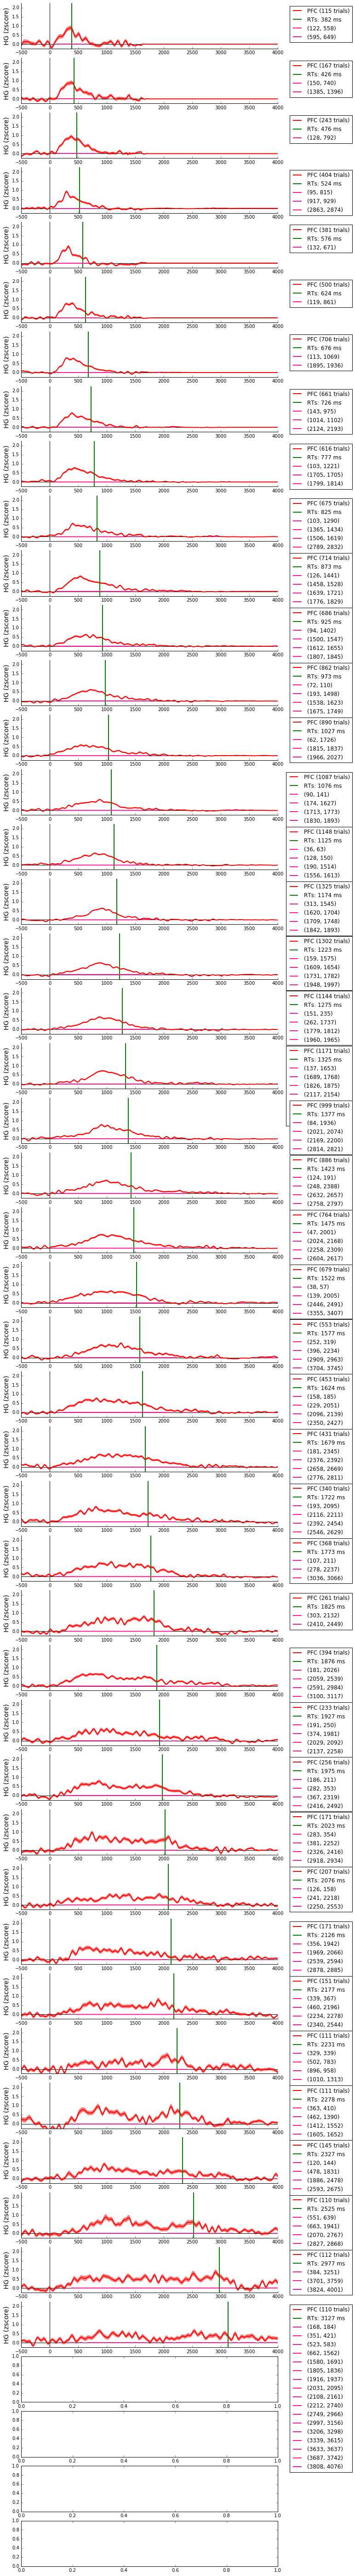

In [149]:
df_idx = pd.DataFrame(columns = ['start_idx','end_idx'])

#plot - only 1 trace with significant windows on x axis
f, ax = plt.subplots(47, 1, figsize = (10,100))
rts, lats =[[] for i in range(2)]
cnt, start_i, start_i_resp, new_b = [0 for i in range(4)]

for i, b in enumerate(bins):
    if i > 1:
        start_i = end_i+1
    
    try:
        end_i = np.where(allRTs <= (b))[-1][-1]
    except:
        end_i = 0
    
    previous_b = new_b #keep track of previous and current bin, for labeling
    new_b = b
    
    if len(np.arange(start_i, end_i+1)) < minimum_number_of_trials:
        continue
    
    data = alldata[start_i:end_i+1,:]
    rts.append(allRTs[start_i:end_i+1].mean())

    #save data
    filename = os.path.join(savedir, 'trace_data', 'trace_data_%s_%ims.mat' %(p, rt))
    spio.savemat(filename, {'data':data, 'rt': allRTs[start_i:end_i+1]})
    filename = os.path.join(savedir, 'trace_data', 'trace_data_%s_%ims_mean.mat' %(p, rt))
    spio.savemat(filename, {'data':data.mean(axis = 0)})
    
    #calculate windows
    H = H_dur[str(np.floor(rts[-1]))]
    
    difference = np.diff(H, n = 1, axis = 0)
    start_idx = np.where(difference==1)[0]+1
    end_idx = np.where(difference == -1)[0]

    if start_idx.size > end_idx.size: #last chunk goes until end
        end_idx = np.append(end_idx, int(data.shape[1]-abs(bl_st)))

    elif start_idx.size < end_idx.size:
        start_idx = np.append(0, start_idx) #starts immediately significant

    if (start_idx.size!=0):
        if (start_idx[0] > end_idx[0]): #starts immediately significant
            start_idx = np.append(0, start_idx)

    if (start_idx.size!=0):
        if (end_idx[-1] < start_idx[-1]):#significant until end
            end_idx = np.append(end_idx, int(data.shape[1]-abs(bl_st)))

    #plot   
    ax[cnt].axhline(y = 0, color = 'k', lw = 1)
    ax[cnt].axvline(x = 0, color = 'k', lw = 1)

    ax[cnt].plot(np.arange(-500, data.shape[1]-500), data.mean(axis = 0), color = c, lw = 2, label = '%s (%i trials)' %(p, len(allRTs[start_i:end_i+1])))
    sem = np.std(data, axis = 0)/np.sqrt(data.shape[0])
    ax[cnt].fill_between(np.arange(-500, data.shape[1]-500), data.mean(axis = 0)+sem, data.mean(axis=0)-sem, alpha = 0.5, zorder = 0, edgecolor = 'None', facecolor = c, label = None)

    ax[cnt].axvline(x = allRTs[start_i:end_i+1].mean(), color = 'g', lw = 2, label = 'RTs: %i ms' %(allRTs[start_i:end_i+1].mean())) 

    if start_idx.size>0:
        for i, s in enumerate(start_idx):
            tmp = np.arange(s, end_idx[i])
            start = s
            finish = end_idx[i]
            ax[cnt].plot(tmp, np.zeros(tmp.size), color = 'deeppink', linewidth = 2, label = (start, finish))
            
        tmp = pd.DataFrame([start_idx, end_idx]).transpose()
        tmp = tmp.set_index(np.tile(np.floor(rts[-1]), len(start_idx)))
        tmp.columns = ['start_idx','end_idx']
        df_idx = df_idx.append(tmp)

    ax[cnt].autoscale(tight = True)
    ax[cnt].spines['top'].set_visible(False)
    ax[cnt].spines['right'].set_visible(False)
    ax[cnt].get_xaxis().tick_bottom()
    ax[cnt].get_yaxis().tick_left()
    ax[cnt].set_ylabel('HG (zscore)', fontsize = 14)
    ax[cnt].set_ylim([-0.25, 2.25])
    ax[cnt].set_xlim([-500, 4000])
    
    handles, labels = ax[cnt].get_legend_handles_labels()
    lgnd = ax[cnt].legend(handles, labels, loc='upper right', bbox_to_anchor=(1.3,1))            
                
    cnt += 1
    
filename = os.path.join(savedir, 'trace_data','sigvalues', 'binned_RTs_sigwindow_%s.png' %(p))
f.savefig(filename, bbox_extra_artists=(lgnd,), bbox_inches='tight')

filename = os.path.join(savedir, 'trace_data', 'sigvalues', 'binned_RTs_sigwindow_%s.csv' %(p))
df_idx.to_csv(filename)


In [150]:
savedir

'/home/knight/matar/MATLAB/DATA/Avgusta/PCA/bins/byROI'

## custom bins

In [165]:
minimum_number_of_trials = 100
filename = os.path.join(savedir, 'rawdata','PFC_all.mat')
data_dict = loadmat(filename)
alldata, allRTs = [data_dict[k] for k in ['PFC_all', 'allRTs']]
p = 'PFC'
c = 'red'

minimum_number_of_trials = 50
filename = os.path.join(savedir, 'rawdata','motor_all.mat')
data_dict = loadmat(filename)
alldata_resp, allRTs_resp = [data_dict[k] for k in ['motor_all', 'allRTs_resp']]
p = 'motor'
c = 'blue'

minimum_number_of_trials = 50
filename = os.path.join(savedir, 'rawdata','sensory_all.mat')
data_dict = loadmat(filename)
alldata_stim, allRTs_stim = [data_dict[k] for k in ['sensory_all', 'allRTs_sensory']]
p = 'sensory'
c = 'gold'

In [162]:
np.array(rts).astype(int)

array([ 382,  426,  476,  524,  576,  624,  676,  726,  777,  825,  873,
        925,  973, 1027, 1076, 1125, 1174, 1223, 1275, 1325, 1377, 1423,
       1475, 1522, 1577, 1624, 1679, 1722, 1773, 1825, 1876, 1927, 1975,
       2023, 2076, 2126, 2177, 2231, 2278, 2327, 2525, 2977, 3127])

(686, 542)
(1144, 639)
(453, 279)
(256, 150)
(145, 94)
/home/knight/matar/MATLAB/DATA/Avgusta/PCA/bins/byROI


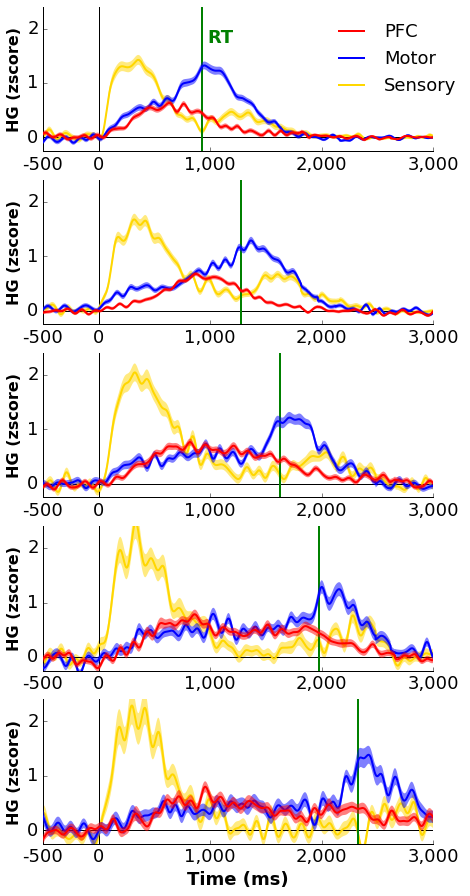

In [177]:
bins = np.arange(allRTs_PFC.min(), allRTs_PFC.max(), 50)

f, ax = plt.subplots(5, 1, figsize = (7,15))

binlist =[925, 1275, 1624, 1975, 2327]

cnt = 0
start_i = 0
start_i_resp = 0
new_b = 0
rts = []

for i, b in enumerate(bins):
    if i > 1:
        start_i = end_i+1
        start_i_resp = end_i_resp+1
        start_i_stim = end_i_stim+1
    end_i = np.where(allRTs <= (b))[-1][-1]
    end_i_resp = np.where(allRTs_resp <= (b))[-1][-1] #define resp bins based on stimulus RTs
    try:
        end_i_stim = np.where(allRTs_stim <= (b))[-1][-1]
    except:
        end_i_stim = 0
    
    previous_b = new_b #keep track of previous and current bin, for labeling
    new_b = b
    
    if len(np.arange(start_i, end_i+1))<100:
        continue
        
    if len(np.arange(start_i_resp, end_i_resp+1))<50:
        continue
        
    if len(np.arange(start_i_stim, end_i_stim+1))<50:
        continue
                
    data = alldata[start_i:end_i+1,:]
    data_resp = alldata_resp[start_i_resp:end_i_resp+1,:]
    data_stim = alldata_stim[start_i_stim:end_i_stim+1,:]
        
    rt = allRTs[start_i:end_i+1].mean()
    rts.append(rt)
    
    if int(rts[-1]) not in (binlist):
        continue

    #plot
    ax[cnt].axhline(y = 0, color = 'k', lw = 1)
    ax[cnt].axvline(x = 0, color = 'k', lw = 1)
    

    ax[cnt].plot(np.arange(-500, data.shape[1]-500), data.mean(axis = 0), color = 'r', lw = 2, label = 'PFC', zorder = 10)# (%i trials)') %(len(allRTs[start_i:end_i+1])))
    sem = np.std(data, axis = 0)/np.sqrt(data.shape[0])
    ax[cnt].fill_between(np.arange(-500, data.shape[1]-500), data.mean(axis = 0)+sem, data.mean(axis=0)-sem, alpha = 0.5, zorder = 10, edgecolor = 'None', facecolor = 'r', label = None)

    ax[cnt].plot(np.arange(-500, data_resp.shape[1]-500), data_resp.mean(axis = 0), color = 'b', lw = 2, label = 'Motor', zorder = 9)# (%i trials)') %(len(allRTs_resp[start_i_resp:end_i_resp+1])))
    sem = np.std(data_resp, axis = 0)/np.sqrt(data_resp.shape[0])
    ax[cnt].fill_between(np.arange(-500, data_resp.shape[1]-500), data_resp.mean(axis = 0)+sem, data_resp.mean(axis=0)-sem, alpha = 0.5, zorder = 9, edgecolor = 'None', facecolor = 'blue', label = None)

    ax[cnt].plot(np.arange(-500, data_stim.shape[1]-500), data_stim.mean(axis = 0), color = 'gold', lw = 2, label = 'Sensory')# (%i trials)') %(len(allRTs_resp[start_i_resp:end_i_resp+1])))
    sem = np.std(data_stim, axis = 0)/np.sqrt(data_stim.shape[0])
    ax[cnt].fill_between(np.arange(-500, data_stim.shape[1]-500), data_stim.mean(axis = 0)+sem, data_stim.mean(axis=0)-sem, alpha = 0.5, zorder = 0, edgecolor = 'None', facecolor = 'gold', label = None)
    
    ax[cnt].axvline(x = rt, color = 'g', lw = 2)#, label = 'RT: %i ms' %(allRTs[start_i:end_i+1].mean()))
    
    ax[cnt].autoscale(tight = True)
    ax[cnt].spines['top'].set_visible(False)
    ax[cnt].spines['right'].set_visible(False)
    ax[cnt].get_xaxis().tick_bottom()
    ax[cnt].get_yaxis().tick_left()
    ax[cnt].set_ylabel('HG (zscore)', fontsize = 16, fontweight = 'bold')
    ax[cnt].set_ylim([-0.25, 2.4])
    ax[cnt].set_xlim([-500, 3000])
    ax[cnt].set_xticks([-500, 0, 1000, 2000, 3000])
    ax[cnt].set_yticks(np.arange(0, 3, 1))

    ax[cnt].get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax[cnt].xaxis.set_tick_params(labelsize = 18)
    ax[cnt].yaxis.set_tick_params(labelsize = 18)
    #ax[cnt].tick_params( axis='both', which = 'both', top = 'off', bottom = 'off', right = 'off', left = 'off')
                    
    handles, labels = ax[0].get_legend_handles_labels()
    lgnd = ax[0].legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1,1), frameon = False, fontsize = 18)
 
    print (len(allRTs[start_i:end_i+1]),(len(allRTs_resp[start_i_resp:end_i_resp+1])))
    
    cnt += 1
    
ax[cnt-1].set_xlabel('Time (ms)', fontsize = 18, fontweight = 'bold')
            
    
    
ax[0].annotate('RT', xy = (binlist[0]+50, 1.75), color = 'g', fontsize = 18, weight = 'bold')
#ax[1].annotate('sustained', xy = (40, 1.1), color = 'r', fontsize = 14, weight = 'bold')
#ax[1].annotate('response', xy = (750, 1.1), color = 'b', fontsize = 14, weight = 'bold')
                 
filename = os.path.join(savedir, 'binned_RTs_custom_all.png')

f.savefig(filename,bbox_inches='tight', dpi = 150)

print savedir

## generate RTs for a bin

In [111]:
bins

array([ 333,  383,  433,  483,  533,  583,  633,  683,  733,  783,  833,
        883,  933,  983, 1033, 1083, 1133, 1183, 1233, 1283, 1333, 1383,
       1433, 1483, 1533, 1583, 1633, 1683, 1733, 1783, 1833, 1883, 1933,
       1983, 2033, 2083, 2133, 2183, 2233, 2283, 2333, 2383, 2433, 2483,
       2533, 2583, 2633, 2683, 2733, 2783, 2833, 2883, 2933, 2983, 3033,
       3083, 3133, 3183, 3233, 3283, 3333, 3383, 3433, 3483, 3533, 3583,
       3633, 3683, 3733, 3783, 3833, 3883, 3933])

In [109]:
bins = np.arange(allRTs.min(), allRTs.max(), 50)

rt, lats =[[] for i in range(2)]
rts = dict()
cnt, start_i, start_i_resp, new_b = [0 for i in range(4)]

for i, b in enumerate(bins):
    if i > 1:
        start_i = end_i+1
    end_i = np.where(allRTs <= (b))[-1][-1]
    
    previous_b = new_b #keep track of previous and current bin, for labeling
    new_b = b
    
    print (previous_b, new_b, end_i+1 - start_i, allRTs[start_i:end_i+1].mean())

    if len(np.arange(start_i, end_i+1)) < minimum_number_of_trials:
        continue
    
    rt = allRTs[start_i:end_i+1].mean()
    rts['RT_' + str(int(rt))] = allRTs[start_i:end_i+1]

(0, 333, 1, 333.0)
(333, 383, 8, 349.875)
(383, 433, 19, 406.05263157894734)
(433, 483, 34, 460.20588235294116)
(483, 533, 43, 508.86046511627904)
(533, 583, 56, 557.64285714285711)
(583, 633, 102, 610.39215686274508)
(633, 683, 93, 659.9677419354839)
(683, 733, 133, 706.23308270676694)
(733, 783, 158, 755.66455696202536)
(783, 833, 278, 809.7194244604317)
(833, 883, 366, 859.19125683060111)
(883, 933, 359, 912.91364902506962)
(933, 983, 463, 959.49244060475166)
(983, 1033, 568, 1009.7992957746479)
(1033, 1083, 570, 1058.7052631578947)
(1083, 1133, 657, 1107.1141552511415)
(1133, 1183, 526, 1156.4353612167301)
(1183, 1233, 478, 1206.2280334728034)
(1233, 1283, 413, 1256.9104116222761)
(1283, 1333, 318, 1306.1855345911949)
(1333, 1383, 305, 1355.9803278688526)
(1383, 1433, 288, 1409.1527777777778)
(1433, 1483, 240, 1462.1291666666666)
(1483, 1533, 193, 1510.7046632124352)
(1533, 1583, 173, 1556.3526011560693)
(1583, 1633, 184, 1612.125)
(1633, 1683, 141, 1661.4042553191489)
(1683, 1733,

In [98]:
filename = os.path.join(savedir, 'RTs_sensory.mat')
spio.savemat(filename, rts)

In [99]:
data_dict = loadmat(filename)